# Rio de Janeiro Neighborhoods Clustering and HDI Analysis

This notebook presents an analysis of Rio de Janeiro's neighborhoods based on the their venues. A Kmeans model is then used to cluster Rio's neighborhoods as a way to verify some similarities between them. It's also shown the relationship between each neighborhood's HDI with its number of venues. All data related to Rio's neighborhoods was acquired in the following wikipedia article: https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH. The venues information were acquired using the Foursquare api and the coordinates of each neighborhoods were acquired using GeoPy library. Finally, to render maps, the Folium library was used.

## Importing Necessary Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

## Importing, Selecting and Cleaning the Neighborhood Data

In [2]:
#reads the html file and selects the pandas dataframe (the dataframe is at index 1)
df = pd.read_html("https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH")[1]

#changes the columns names
columns = ['N', 'Neighborhood', 'Life Expectancy', 'Adult Literacy Rate', "School Frequency", "GPD per Capita", "HDI-L", "HDI-E", "HDI-R", "HDI"]
df.columns = columns

#removes rows that are not a neighborhood
df.drop(df[df["N"] == "—"].index, inplace = True)

#converts the HDI column type to float
df["HDI"] = df["HDI"].astype(float)
df["HDI"] = df["HDI"]/1000

#selects the useful columns
df = df[["Neighborhood", "HDI"]]

In [3]:
df.head()

,Neighborhood,HDI
0,Gávea,0.970
1,Leblon,0.967
2,Jardim Guanabara,0.963
3,Ipanema,0.962
4,Lagoa,0.959


In [4]:
df.shape

(126, 2)

It seems that neighborhoods with the same HDI are grouped together in the same row, let's separate them:

In [5]:
#separates neighborhoods with the same HDI and removes the rows containing multiple neighborhoods
for N, hdi in zip(df["Neighborhood"], df["HDI"]):
    if ', ' in N:
        for n in N.split(', '):
            df = df.append({
                "Neighborhood":n,
                "HDI":hdi
            },  ignore_index=True)
        df.drop(df[df['Neighborhood']==N].index, inplace = True)

In [6]:
#sorts the neighborhoods by HDI
df.sort_values(by=["HDI"], ascending = False, inplace = True)

#resets the indexes
df = df.reset_index(drop=True)

In [7]:
df.head()

,Neighborhood,HDI
0,Gávea,0.970
1,Leblon,0.967
2,Jardim Guanabara,0.963
3,Ipanema,0.962
4,Humaitá,0.959


In [8]:
df.shape

(159, 2)

Now let's get the coordinates for each neighborhood using GeoPy

In [9]:
#gets the latitude and longitude for each neighborhood and adds it to the dataframe
latitudes = []
longitudes = []
for n in df["Neighborhood"]:
    address = "{}, Rio de Janeiro, Rio de Janeiro".format(n)
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitudes += [location.latitude]
    longitudes += [location.longitude]

df["Latitude"] = latitudes
df["Longitude"] = longitudes

In [10]:
df.head()

,Neighborhood,HDI,Latitude,Longitude
0,Gávea,0.970,-22.981424,-43.238324
1,Leblon,0.967,-22.983556,-43.224938
2,Jardim Guanabara,0.963,-22.812836,-43.200779
3,Ipanema,0.962,-22.983956,-43.202216
4,Humaitá,0.959,-22.954641,-43.200480


Visualyzing the neighborhoods on the map using Folium

In [11]:
address = 'Rio de Janeiro, RJ'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Rio de Janeiro using latitude and longitude values
map_rio = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label, hdi in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['HDI']):
    label = folium.Popup(label + " HDI: " + str(hdi), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rio)  
    
map_rio

It looks like GeoPy got the wrong coordinates for Mangueira, other neighborhood with the same name from another city was selected instead. Let's just drop it.

In [12]:
#removes the Mangueira neighborhood
df.drop(df[df["Neighborhood"]=="Mangueira"].index, inplace=True)

## Acquiring the Venues from each Neighborhood

In [13]:
#defining my Foursquare credentials in order to make calls with its api
CLIENT_ID = 'WGBHG55S3WJ1X5IVUQI4MMCTEXPHCSWML2KAOELPASPEOUQM'
CLIENT_SECRET = '3VUTPBJW4EG3ZBFLHAZ0NXCGEYWCTMWTPBMVWOIGAPVC1WQT'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

In [16]:
#defines a function to get the venues from each neighborhood within the radius 
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
rio_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Gávea
Leblon
Jardim Guanabara
Ipanema
Humaitá
Joá
Barra da Tijuca
Lagoa
Flamengo
Jardim Botânico
Laranjeiras
Copacabana
Leme
Urca
Botafogo
Maracanã
Jardim Sulacap
Glória
Méier
Tijuca
Alto da Boa Vista
Todos os Santos
Anil
Vila da Penha
Andaraí
Riachuelo
Moneró
Portuguesa
Campinho
Vila Valqueire
Catete
Vila Isabel
Pechincha
Cachambi
Freguesia
Grumari
Recreio dos Bandeirantes
Lapa
Centro
Higienópolis
Cosme Velho
Santa Teresa
Encantado
Água Santa
Vila Kosmos
Taquara
Vidigal
São Conrado
Cidade Nova
Praça da Bandeira
Bancários
Bonsucesso
Cocotá
Maria da Graça
Del Castilho
Ribeira
Lins de Vasconcelos
Cacuia
Praia da Bandeira
Zumbi
Pitangueiras
Engenho Novo
Ramos
Engenho de Dentro
Abolição
Deodoro
Vila Militar
Campo dos Afonsos
Oswaldo Cruz
Olaria
Bento Ribeiro
Piedade
Quintino Bocaiúva
Rio Comprido
Praça Seca
Sampaio
Jacaré
Rocha
Jardim América
Freguesia
Jardim Carioca
Engenho da Rainha
Brás de Pina
São Cristóvão
Cascadura
Parque Anchieta
Vasco da Gama
Madureira
Tanque
Pilares
Estácio
Curici

In [20]:
rio_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gávea,-22.981424,-43.238324,Instituto Moreira Salles (IMS),-22.981627,-43.239637,Cultural Center
1,Gávea,-22.981424,-43.238324,Empório Jardim,-22.981632,-43.239682,Breakfast Spot
2,Gávea,-22.981424,-43.238324,Sociedade Germania,-22.980419,-43.239628,Athletics & Sports
3,Gávea,-22.981424,-43.238324,Bosque da PUC,-22.980186,-43.234375,College Quad
4,Gávea,-22.981424,-43.238324,Parque da Cidade,-22.981210,-43.242434,Park


In [21]:
rio_venues.shape

(7374, 7)

It's possible that, with a radius of 1000 meters, some neighborhoods overlap, so maybe there are some duplicates in the rio_venues dataframe. Let's drop them.

In [22]:
#drops venues with the same name
rio_venues.drop_duplicates(subset = "Venue", inplace = True)

In [23]:
rio_venues.shape

(4670, 7)

Indeed there were thousands of duplicates.

In [26]:
#resets the indexes
rio_venues.reset_index()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Gávea,-22.981424,-43.238324,Instituto Moreira Salles (IMS),-22.981627,-43.239637,Cultural Center
1,1,Gávea,-22.981424,-43.238324,Empório Jardim,-22.981632,-43.239682,Breakfast Spot
2,2,Gávea,-22.981424,-43.238324,Sociedade Germania,-22.980419,-43.239628,Athletics & Sports
3,3,Gávea,-22.981424,-43.238324,Bosque da PUC,-22.980186,-43.234375,College Quad
4,4,Gávea,-22.981424,-43.238324,Parque da Cidade,-22.981210,-43.242434,Park
5,5,Gávea,-22.981424,-43.238324,Couve Flor,-22.980280,-43.233996,Brazilian Restaurant
6,6,Gávea,-22.981424,-43.238324,Confeitaria Lorena,-22.982174,-43.238086,Bakery
7,7,Gávea,-22.981424,-43.238324,Planetário da Gávea,-22.977895,-43.230278,Planetarium
8,8,Gávea,-22.981424,-43.238324,Hortifruti,-22.977016,-43.230147,Fruit & Vegetable Store
9,9,Gávea,-22.981424,-43.238324,Teatro Municipal Maria Clara Machado,-22.978975,-43.230198,Theater


## Analyzing the Neighborhoods

Now let's compare the neighborhoods by HDI and number of venues. First, let's create the "Number of Venues" column to the first dataframe.

In [27]:
#adds the "Number of Venues" column
df["Number of Venues"] = np.zeros(df.shape[0])

In [28]:
#adds the number of venues to each row
for neighborhood in df["Neighborhood"]:
    if neighborhood in rio_venues["Neighborhood"].value_counts().index:
        df["Number of Venues"].loc[df["Neighborhood"]==neighborhood] += rio_venues["Neighborhood"].value_counts().loc[neighborhood]

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
df.head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues
0,Gávea,0.970,-22.981424,-43.238324,24.0
1,Leblon,0.967,-22.983556,-43.224938,93.0
2,Jardim Guanabara,0.963,-22.812836,-43.200779,90.0
3,Ipanema,0.962,-22.983956,-43.202216,90.0
4,Humaitá,0.959,-22.954641,-43.200480,93.0


Now let's visualize the data and compare de average number of venues for the neighborhoods with a HDI higher or equal than 0.8 and the neighborhoods with a HDI lower than 0.8.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

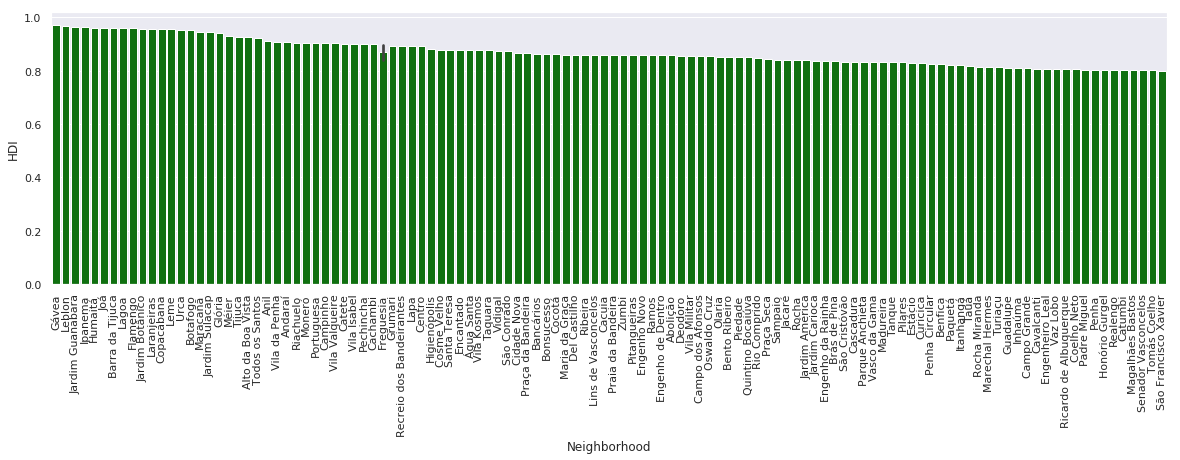

In [46]:
plt.figure(figsize=(20,5))
sns.barplot(x='Neighborhood', y='HDI', data=df.loc[df["HDI"]>=0.8], color='green')
plt.xticks(rotation=90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

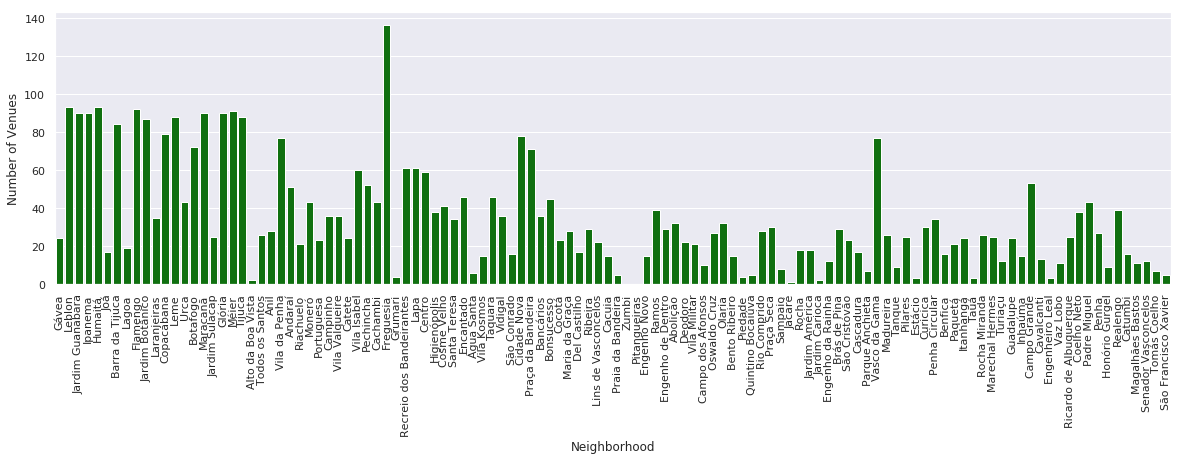

In [50]:
plt.figure(figsize=(20,5))
sns.barplot(x='Neighborhood', y='Number of Venues', data=df.loc[df["HDI"]>=0.8], color='green')
plt.xticks(rotation=90)

In [54]:
print("Average number of venues of the neighborhoods with a HDI higher or equal to 0.8: {}".format(df["Number of Venues"].loc[df["HDI"]>=0.8].mean()))

Average number of venues of the neighborhoods with a HDI higher or equal to 0.8: 35.401709401709404


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

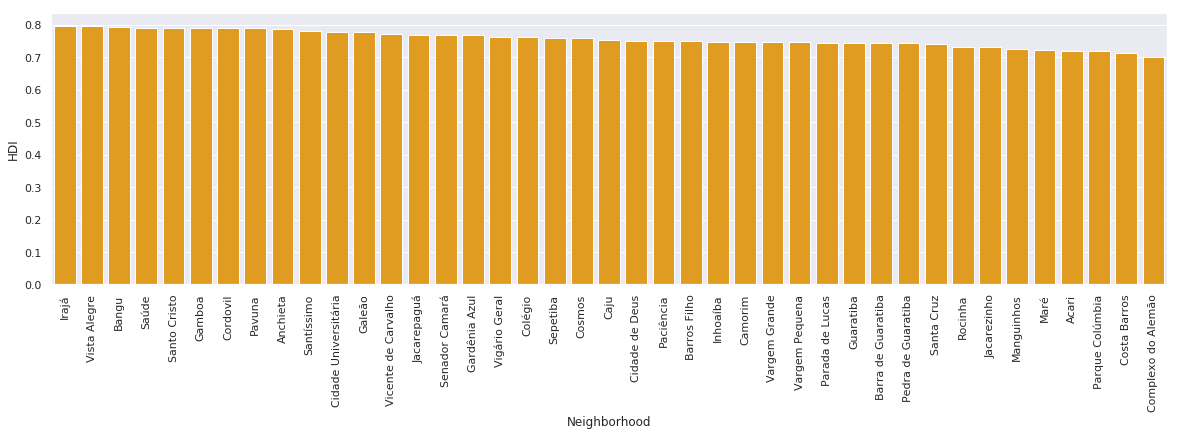

In [51]:
plt.figure(figsize=(20,5))
sns.barplot(x='Neighborhood', y='HDI', data=df.loc[df["HDI"]<0.8], color='orange')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

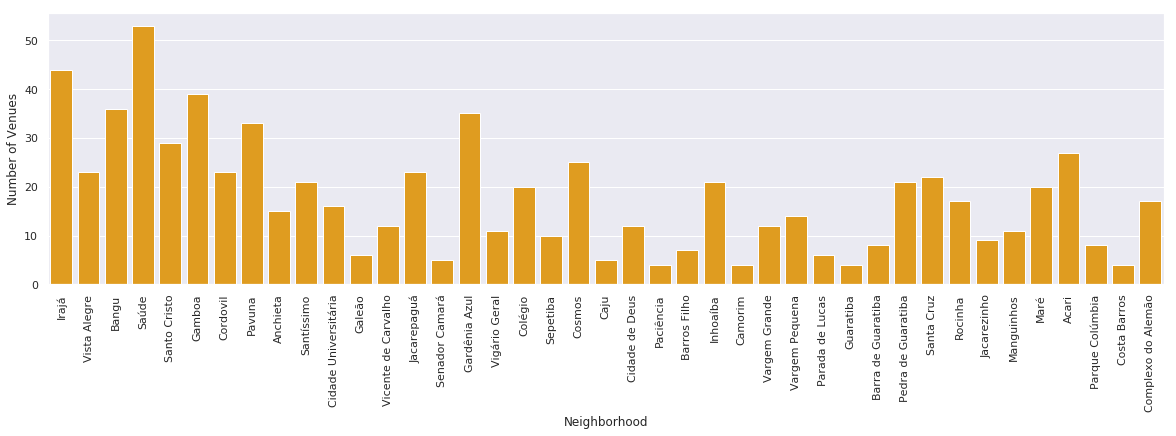

In [52]:
plt.figure(figsize=(20,5))
sns.barplot(x='Neighborhood', y='Number of Venues', data=df.loc[df["HDI"]<0.8], color='orange')
plt.xticks(rotation=90)

In [56]:
print("Average number of venues of the neighborhoods with a HDI lower than 0.8: {}".format(df["Number of Venues"].loc[df["HDI"]<0.8].mean()))

Average number of venues of the neighborhoods with a HDI lower than 0.8: 17.853658536585368


Looks like there is some correlation between the number of venues of a neighborhood and its HDI, the average number of venues of the neighborhoods with a HDI higher or equal than 0.8 is twice the average number of venues of the neighborhoods with a lower HDI.

## Clustering the Neighborhoods

In [73]:
# one hot encoding
rio_onehot = pd.get_dummies(rio_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rio_onehot['Neighborhood'] = rio_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rio_onehot.columns[-1]] + list(rio_onehot.columns[:-1])
rio_onehot = rio_onehot[fixed_columns]

rio_onehot.head()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Central Brazilian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Dive Shop,Dog Run,Drugstore,Electronics Store,Empada House,Empanada Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Lake,Laser Tag,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Radio Station,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Rugby Stadium,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Southeastern Bra

In [74]:
rio_grouped = rio_onehot.groupby('Neighborhood').mean().reset_index()
rio_grouped.head()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Central Brazilian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Dive Shop,Dog Run,Drugstore,Electronics Store,Empada House,Empanada Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Lake,Laser Tag,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Radio Station,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Rugby Stadium,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Southeastern Bra

Now let's get the 10 most common venues of each neighborhood.

In [75]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [76]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rio_grouped['Neighborhood']

for ind in np.arange(rio_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rio_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abolição,BBQ Joint,Food Truck,Soccer Field,Bar,Deli / Bodega,Gym / Fitness Center,Gym,Music Venue,General Entertainment,Burger Joint
1,Acari,Market,Plaza,Burger Joint,Bus Station,Buffet,Supermarket,Brazilian Restaurant,Gym / Fitness Center,Soccer Field,Snack Place
2,Alto da Boa Vista,Mountain,Scenic Lookout,Zoo,French Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium
3,Anchieta,Plaza,Gym / Fitness Center,Pizza Place,Fast Food Restaurant,Nightclub,Fruit & Vegetable Store,Gym,Pet Store,Church,General Entertainment
4,Andaraí,Bar,Bakery,Gym / Fitness Center,Food Truck,Japanese Restaurant,Music Venue,Gym,Pizza Place,Farmers Market,Plaza


Applying the k-means method do cluster the neighborhoods.

In [77]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

rio_grouped_clustering = rio_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rio_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 4, 2, 4, 4, 2, 4, 4, 4], dtype=int32)

In [78]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

rio_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
rio_merged = rio_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

rio_merged.head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gávea,0.970,-22.981424,-43.238324,24.0,4.0,Sushi Restaurant,Park,Cultural Center,Trail,Theater,Gym,Brazilian Restaurant,Fruit & Vegetable Store,Food Truck,Shopping Plaza
1,Leblon,0.967,-22.983556,-43.224938,93.0,4.0,Brazilian Restaurant,Steakhouse,Bar,Restaurant,Pizza Place,Italian Restaurant,Juice Bar,French Restaurant,Café,Sandwich Place
2,Jardim Guanabara,0.963,-22.812836,-43.200779,90.0,4.0,Brazilian Restaurant,Gym,Pizza Place,Burger Joint,Beach Bar,Japanese Restaurant,Bakery,Bar,Snack Place,Gym / Fitness Center
3,Ipanema,0.962,-22.983956,-43.202216,90.0,4.0,Food Stand,Brazilian Restaurant,Pizza Place,Bar,Italian Restaurant,Japanese Restaurant,Hostel,Hotel,Spa,Burger Joint
4,Humaitá,0.959,-22.954641,-43.200480,93.0,4.0,Bar,Brazilian Restaurant,Café,Vegetarian / Vegan Restaurant,Nightclub,Plaza,Pie Shop,Restaurant,Bakery,Salon / Barbershop


The Foursquare api maybe couldn't find venues for some neighborhoods, so let's drop them.

In [79]:
#drops the neighborhoods with no cluster assigned
rio_merged.dropna(subset=["Cluster Label"], inplace = True)

#converts the type of the Cluster Label column
rio_merged["Cluster Label"] = rio_merged["Cluster Label"].astype(int)

Visualyzing the neighborhoods assigned to a cluster.

In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rio_merged['Latitude'], rio_merged['Longitude'], rio_merged['Neighborhood'], rio_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster Analysis

Let's analyse each cluster and determine their average HDI.

### Cluster 0

In [81]:
rio_merged.loc[rio_merged['Cluster Label'] == 0].head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,Estácio,0.829,-22.916626,-43.203630,3.0,0,Plaza,Tunnel,Zoo,Frame Store,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium
157,Costa Barros,0.713,-22.824700,-43.369839,4.0,0,Plaza,Border Crossing,Mountain,Liquor Store,Zoo,French Restaurant,Food Court,Food Service,Food Stand,Food Truck


In [89]:
rio_merged["HDI"].loc[rio_merged['Cluster Label'] == 0].mean()

0.7709999999999999

### Cluster 1

In [85]:
rio_merged.loc[rio_merged['Cluster Label'] == 1].head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,Jacaré,0.839,-22.893117,-43.2572,1.0,1,Market,Zoo,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain


In [90]:
rio_merged["HDI"].loc[rio_merged['Cluster Label'] == 1].mean()

0.839

## Cluster 2

In [86]:
rio_merged.loc[rio_merged['Cluster Label'] == 2].head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Lagoa,0.959,-22.962466,-43.202488,19.0,2,Scenic Lookout,Gym / Fitness Center,Japanese Restaurant,Trail,Dive Bar,Pool,Plaza,Playground,Pizza Place,Chinese Restaurant
16,Jardim Sulacap,0.944,-22.895680,-43.392997,25.0,2,Gym,Plaza,Restaurant,Food Truck,Toll Booth,Tunnel,Snack Place,Bar,Toll Plaza,Bakery
21,Todos os Santos,0.922,-22.894563,-43.285060,26.0,2,Soccer Stadium,Bar,Furniture / Home Store,Pizza Place,Clothing Store,Tattoo Parlor,History Museum,Shopping Mall,Theater,Snack Place
23,Vila da Penha,0.909,-22.843507,-43.310058,77.0,2,Bakery,Pizza Place,Brazilian Restaurant,Bar,Plaza,Fast Food Restaurant,Japanese Restaurant,Gym / Fitness Center,Snack Place,Steakhouse
25,Riachuelo,0.905,-22.902695,-43.255175,21.0,2,Gym,Restaurant,Brazilian Restaurant,Train Station,Farmers Market,Organic Grocery,Supermarket,Gym / Fitness Center,Gymnastics Gym,Motel


In [93]:
rio_merged["HDI"].loc[rio_merged['Cluster Label'] == 2].mean()

0.8243289473684211

### Cluster 3

In [87]:
rio_merged.loc[rio_merged['Cluster Label'] == 3].head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,Jardim Carioca,0.836,-22.805249,-43.193195,2.0,3,Samba School,Asian Restaurant,Zoo,French Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium


In [91]:
rio_merged["HDI"].loc[rio_merged['Cluster Label'] == 3].mean()

0.836

### Cluster 4

In [88]:
rio_merged.loc[rio_merged['Cluster Label'] == 4].head()

,Neighborhood,HDI,Latitude,Longitude,Number of Venues,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gávea,0.970,-22.981424,-43.238324,24.0,4,Sushi Restaurant,Park,Cultural Center,Trail,Theater,Gym,Brazilian Restaurant,Fruit & Vegetable Store,Food Truck,Shopping Plaza
1,Leblon,0.967,-22.983556,-43.224938,93.0,4,Brazilian Restaurant,Steakhouse,Bar,Restaurant,Pizza Place,Italian Restaurant,Juice Bar,French Restaurant,Café,Sandwich Place
2,Jardim Guanabara,0.963,-22.812836,-43.200779,90.0,4,Brazilian Restaurant,Gym,Pizza Place,Burger Joint,Beach Bar,Japanese Restaurant,Bakery,Bar,Snack Place,Gym / Fitness Center
3,Ipanema,0.962,-22.983956,-43.202216,90.0,4,Food Stand,Brazilian Restaurant,Pizza Place,Bar,Italian Restaurant,Japanese Restaurant,Hostel,Hotel,Spa,Burger Joint
4,Humaitá,0.959,-22.954641,-43.200480,93.0,4,Bar,Brazilian Restaurant,Café,Vegetarian / Vegan Restaurant,Nightclub,Plaza,Pie Shop,Restaurant,Bakery,Salon / Barbershop


In [92]:
rio_merged["HDI"].loc[rio_merged['Cluster Label'] == 4].mean()

0.8576447368421052

By looking at the map we conclude that the k-means method divided the neighborhood into 2 large clusters (2 and 4), and 3 smaller ones (0, 1 and 3). The 2 largests clusters seems to be divided into groups of higher HDI neighborhoods (cluster 4) and lower HDI neighborhoods (cluster 2).